In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="iyLsqEim9nAoDa24N72g")
project = rf.workspace("industrial-engineer").project("cotton-disease-zrbov")
version = project.version(12)
dataset = version.download("coco")

In [ ]:
!python -m pip install --upgrade pip

!pip install supervision==0.3.0

!pip install transformers

!pip install pytorch-lightning

!pip install timm

!pip install cython

!pip install pycocotools

!pip install scipy

!pip install roboflow

In [ ]:
import supervision as sv
import transformers

sv.__version__, transformers.__version__


In [ ]:
import pytorch_lightning
print(pytorch_lightning.__version__)

In [ ]:
import torch
torch.cuda.empty_cache()
import gc
gc.collect()

Coco Dataloader

In [ ]:
import os
import torchvision
from transformers import DetrImageProcessor
image_processor=DetrImageProcessor.from_pretrained('facebook/detr-resnet-50')

In [ ]:
dataset='/kaggle/working/Cotton-Disease-12/'
ANNOTATION_FILE_NAME='_annotations.coco.json'
TRAIN_DIRECTORY=os.path.join(dataset,'train')
TEST_DIRECTORY=os.path.join(dataset,'test')
VAL_DIRECTORY=os.path.join(dataset,'valid')

**COCO Class**

In [ ]:
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self, 
        image_directory_path: str, 
        image_processor, 
        train: bool = True
    ):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)        
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target
        
TRAIN_DATASET = CocoDetection(image_directory_path=TRAIN_DIRECTORY, image_processor=image_processor, train=True)
VAL_DATASET = CocoDetection(image_directory_path=VAL_DIRECTORY, image_processor=image_processor, train=False)
TEST_DATASET = CocoDetection(image_directory_path=TEST_DIRECTORY, image_processor=image_processor, train=False)

print("Number of training examples:", len(TRAIN_DATASET))
print("Number of validation examples:", len(VAL_DATASET))
print("Number of test examples:", len(TEST_DATASET))

In [ ]:

import random
import cv2
import numpy as np


# select random image
image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons 
image = TRAIN_DATASET.coco.loadImgs(image_id)[0]
annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TRAIN_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)

# we will use id2label function for training
categories = TRAIN_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}

labels = [
    f"{id2label[class_id]}" 
    for _, _, class_id, _ 
    in detections
]

box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

In [ ]:
%matplotlib inline
sv.show_frame_in_notebook(image,(10,10))

In [ ]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    pixel_values=[item[0] for item in batch]
    encoding=image_processor.pad(pixel_values,return_tensors='pt')
    labels=[item[1] for item in batch]
    return{
        'pixel_values':encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels':labels
    }


TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=8, shuffle=True)
VAL_DATALOADER = DataLoader(dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=8)
TEST_DATALOADER = DataLoader(dataset=TEST_DATASET, collate_fn=collate_fn, batch_size=8)

In [ ]:
import pytorch_lightning as pl
from transformers import DetrForObjectDetection
import torch

class Detr(pl.LightningModule):
    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()
        self.model = DetrForObjectDetection.from_pretrained(
            pretrained_model_name_or_path="facebook/detr-resnet-50", 
            num_labels=len(id2label),
            ignore_mismatched_sizes=True
        )
        
        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step, and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation/loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())
            
        return loss

    def configure_optimizers(self):
        # DETR authors decided to use different learning rate for backbone
        # you can learn more about it here: 
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L22-L23
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L131-L139
        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        return TRAIN_DATALOADER

    def val_dataloader(self):
        return VAL_DATALOADER

In [ ]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

batch = next(iter(TRAIN_DATALOADER))
outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

In [ ]:
from pytorch_lightning import Trainer

# settings
MAX_EPOCHS = 50

trainer = Trainer( max_epochs=MAX_EPOCHS, gradient_clip_val=0.1, accumulate_grad_batches=16, log_every_n_steps=5)

trainer.fit(model)

In [ ]:
import torch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = 'custom-model'
model.model.save_pretrained(MODEL_PATH)

# loading model
model = DetrForObjectDetection.from_pretrained(MODEL_PATH)
model.to(DEVICE)

Image # 201


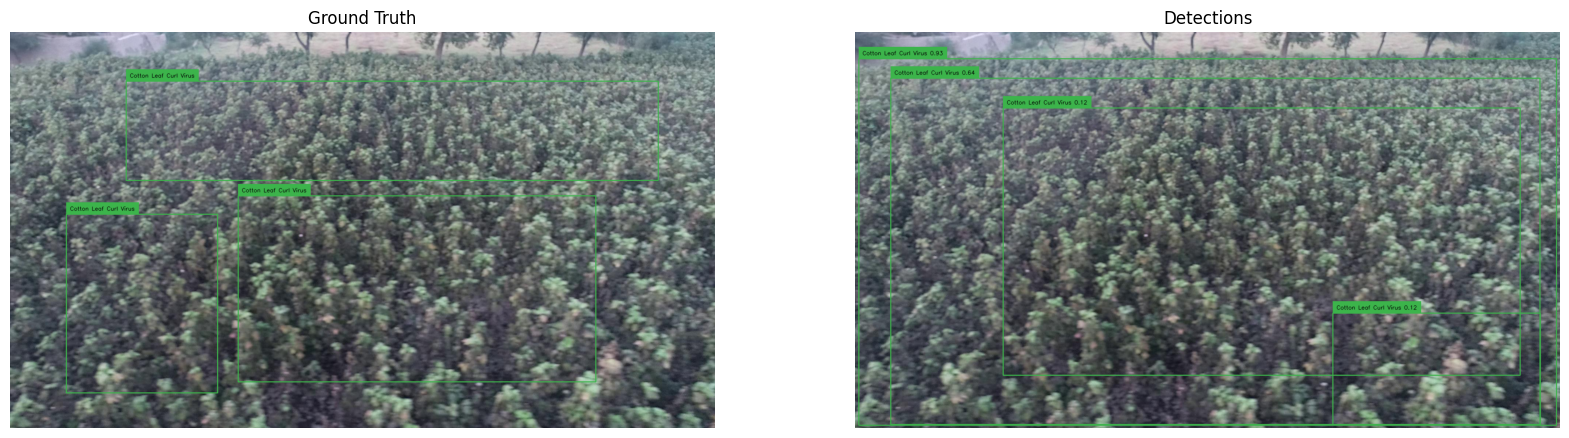

In [72]:
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

#utils
categories=TEST_DATASET.coco.cats
id2label={k:v['name'] for k,v in categories.items()}
box_annotator=sv.BoxAnnotator()

#Selecting the random image
image_ids=TEST_DATASET.coco.getImgIds()
image_id=random.choice(image_ids)
print('Image # {}'.format(image_id))

#load image and annotations
image=TEST_DATASET.coco.loadImgs(image_id)[0]
annotations= TEST_DATASET.coco.imgToAnns[image_id]
image_path=os.path.join(TEST_DATASET.root, image['file_name'])
image=cv2.imread(image_path)

#annotations
detections=sv.Detections.from_coco_annotations(coco_annotation=annotations)
labels=[f"{id2label[class_id]}" for _,_,class_id,_,in detections]
frame_ground_truth=box_annotator.annotate(scene=image.copy(),detections=detections, labels=labels)
CONFIDENCE_TRESHOLD=0.1

#Annotate Detection
with torch.no_grad():

    #load image and predict 
    inputs=image_processor(images=image, return_tensors='pt').to(DEVICE)
    outputs=model(**inputs)

    target_sizes=torch.tensor([image.shape[:2]]).to(DEVICE)
    results=image_processor.post_process_object_detection(
        outputs=outputs,
        threshold=CONFIDENCE_TRESHOLD,
        target_sizes=target_sizes
    )[0]

    detections = sv.Detections.from_transformers(transformers_results=results)
    labels = [f"{id2label[class_id]} {confidence:.2f}" for _, confidence, class_id, _ in detections]
    frame_detections = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(cv2.cvtColor(frame_ground_truth, cv2.COLOR_BGR2RGB))
axs[0].axis('off')
axs[0].set_title('Ground Truth')

axs[1].imshow(cv2.cvtColor(frame_detections, cv2.COLOR_BGR2RGB))
axs[1].axis('off')
axs[1].set_title('Detections')

plt.show()
    

In [64]:
import numpy as np
import torch
import supervision as sv
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

In [65]:
def evaluate_coco(test_dataset, model, image_processor, device, confidence_threshold=0.1):
    coco_gt = test_dataset.coco  # Ground Truth COCO object
    coco_dt = []  # Predictions in COCO format

    for img_id in test_dataset.coco.getImgIds():
        # Load image and annotations
        image_info = test_dataset.coco.loadImgs(img_id)[0]
        image_path = os.path.join(test_dataset.root, image_info['file_name'])
        image = cv2.imread(image_path)

        # Model prediction
        with torch.no_grad():
            inputs = image_processor(images=image, return_tensors='pt').to(device)
            outputs = model(**inputs)
            target_sizes = torch.tensor([image.shape[:2]]).to(device)
            results = image_processor.post_process_object_detection(
                outputs=outputs, 
                threshold=confidence_threshold, 
                target_sizes=target_sizes
            )[0]

        # Convert detections to COCO format
        for box, score, label in zip(results['boxes'], results['scores'], results['labels']):
            coco_dt.append({
                'image_id': img_id,
                'category_id': label.item(),
                'bbox': [box[0].item(), box[1].item(), (box[2]-box[0]).item(), (box[3]-box[1]).item()],
                'score': score.item()
            })

    # Load ground truth and predictions into COCOeval
    coco_dt = coco_gt.loadRes(coco_dt)
    coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    return coco_eval.stats  # Returns [AP@0.5:0.95, AP@0.5, AP@0.75, AP_small, AP_medium, AP_large, AR_max=1, ...]

In [66]:
def evaluate_classification(test_dataset, model, image_processor, device, confidence_threshold=0.1):
    y_true = []
    y_pred = []

    for img_id in test_dataset.coco.getImgIds():
        # Load image and annotations
        image_info = test_dataset.coco.loadImgs(img_id)[0]
        image_path = os.path.join(test_dataset.root, image_info['file_name'])
        image = cv2.imread(image_path)
        annotations = test_dataset.coco.imgToAnns[img_id]

        # Ground Truth labels
        gt_labels = [ann['category_id'] for ann in annotations]
        y_true.extend(gt_labels)

        # Model prediction
        with torch.no_grad():
            inputs = image_processor(images=image, return_tensors='pt').to(device)
            outputs = model(**inputs)
            target_sizes = torch.tensor([image.shape[:2]]).to(device)
            results = image_processor.post_process_object_detection(
                outputs=outputs, 
                threshold=confidence_threshold, 
                target_sizes=target_sizes
            )[0]

        # Predicted labels
        pred_labels = results['labels'].cpu().numpy()
        y_pred.extend(pred_labels)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=id2label.values(), yticklabels=id2label.values())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=id2label.values()))

    return cm

In [68]:
# Run COCO Evaluation
coco_stats = evaluate_coco(TEST_DATASET, model, image_processor, DEVICE)
print("COCO Evaluation Metrics:")
print(f"mAP@0.5:0.95 = {coco_stats[0]:.4f}")
print(f"mAP@0.5 (IoU) = {coco_stats[1]:.4f}")
print(f"mAP@0.75 (IoU) = {coco_stats[2]:.4f}")
print(f"AP (small objects) = {coco_stats[3]:.4f}")
print(f"AP (medium objects) = {coco_stats[4]:.4f}")
print(f"AP (large objects) = {coco_stats[5]:.4f}")



Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.47s).
Accumulating evaluation results...
DONE (t=0.09s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.092
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.135
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.085
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.095
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.102
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.153
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.198
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10